2024-08-19 22:26:35,640 - INFO - Data loaded. Shape: (2770, 66)
2024-08-19 22:26:35,642 - INFO - Seasons in data: [2018 2019 2020 2021 2022 2023]
2024-08-19 22:26:35,646 - INFO - Data cleaned. Remaining shape: (2742, 62)
2024-08-19 22:26:35,653 - INFO - Starting encoding process.
2024-08-19 22:26:35,663 - INFO - Encoding completed. Data shape: (2742, 63). Features saved.
2024-08-19 22:26:35,664 - INFO - Saving encoders, scalers, and feature names.
2024-08-19 22:26:35,678 - INFO - Artifacts saved successfully.
2024-08-19 22:26:35,679 - INFO - Data preprocessing completed. Ready for model training.


New features added and irrelevant columns dropped.


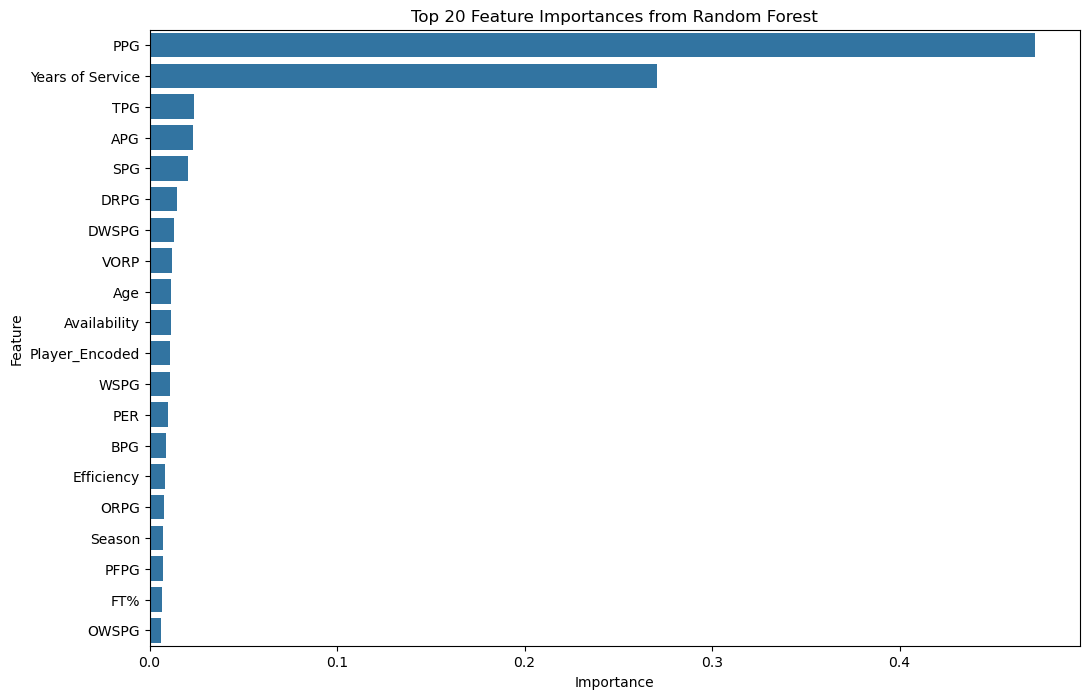


Tree-based feature importances:
             Feature  Importance
11               PPG    0.472460
2   Years of Service    0.270644
13               TPG    0.023479
12               APG    0.023373
14               SPG    0.020618
24              DRPG    0.014516
20             DWSPG    0.013068
8               VORP    0.012142
1                Age    0.011218
16      Availability    0.011154
25    Player_Encoded    0.010957
19              WSPG    0.010663
7                PER    0.009862
15               BPG    0.008544
17        Efficiency    0.008163
23              ORPG    0.007709
0             Season    0.007337
22              PFPG    0.007270
6                FT%    0.006338
21             OWSPG    0.005791


In [19]:
# %%writefile ../src/data_loader_preprocessor.py

import pandas as pd
import numpy as np
import logging
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        logger.info(f"Data loaded. Shape: {data.shape}")
        return data
    except Exception as e:
        logger.error(f"Failed to load data from {file_path}: {e}")
        raise

def format_season(data):
    try:
        data['Season'] = data['Season'].apply(lambda x: int(x.split('-')[0]))
        logger.info(f"Seasons in data: {data['Season'].unique()}")
        return data
    except Exception as e:
        logger.error(f"Failed to format season data: {e}")
        raise

def clean_data(data):
    try:
        data_clean = data.copy()
        columns_to_drop = ['Injury_Periods', '2nd Apron', 'Wins', 'Losses']
        data_clean.drop(columns_to_drop, axis=1, errors='ignore', inplace=True)
        
        percentage_cols = ['3P%', '2P%', 'FT%', 'TS%']
        for col in percentage_cols:
            if col in data_clean.columns:
                data_clean[col] = data_clean[col].fillna(data_clean[col].mean())
        
        data_clean = data_clean.dropna()
        logger.info(f"Data cleaned. Remaining shape: {data_clean.shape}")
        return data_clean
    except Exception as e:
        logger.error(f"Failed to clean data: {e}")
        raise

def engineer_features(data):
    # Calculate per-game statistics to normalize performance data
    per_game_cols = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV']
    for col in per_game_cols:
        data[f'{col[0]}PG'] = data[col] / data['GP']
    
    # Derive additional features to capture important aspects of a player's performance
    data['Availability'] = data['GP'] / 82
    data['SalaryPct'] = data['Salary'] / data['Salary_Cap_Inflated']
    data['Efficiency'] = (data['PTS'] + data['TRB'] + data['AST'] + data['STL'] + data['BLK']) / (data['FGA'] + data['FTA'] + data['TOV'] + 1)
    data['ExperienceSquared'] = data['Years of Service'] ** 2
    data['Days_Injured_Percentage'] = data['Total_Days_Injured'] / data['GP']
    data['WSPG'] = data['WS'] / data['GP']
    data['DWSPG'] = data['DWS'] / data['GP']
    data['OWSPG'] = data['OWS'] / data['GP']
    data['PFPG'] = data['PF'] / data['GP']
    data['ORPG'] = data['ORB'] / data['GP']
    data['DRPG'] = data['DRB'] / data['GP']
    
    # Drop columns used in feature creation or deemed less relevant for modeling
    columns_to_drop = ['GP', '2PA', 'OBPM', 'BPM', 'DBPM', '2P', 'GS', 'PTS', 'AST', 'TRB', 'STL', 'BLK',
                       'TOV', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB',
                       'TS%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'Luxury Tax', '1st Apron',
                       'WS', 'DWS', 'WS/48', 'PF', 'OWS', 'Injured', 
                       'TeamID', 'ValueOverReplacement', 'Salary_Cap', 'Salary_Cap_Inflated'
                       , 'ExperienceSquared', 'Salary Cap', 'BAE',
       'Standard /Non-Taxpayer', 'Taxpayer', 'Team Room /Under Cap']
    
    data.drop(columns_to_drop, axis=1, errors='ignore', inplace=True)
    
    print("New features added and irrelevant columns dropped.")
    return data

def encode_injury_risk(data):
    # Encode injury risk levels for model training
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    data['Injury_Risk'] = data['Injury_Risk'].map(risk_mapping).fillna(0)  # Default to Low if unknown
    return data, risk_mapping

def encode_categorical(data, columns):
    # Encode categorical columns using one-hot encoding
    encoders = {}
    for col in columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(data[[col]])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=data.index)
        data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)
        encoders[col] = encoder
    return data, encoders


def encode_data(data, encoders=None, player_encoder=None):
    print("Columns before encoding:", data.columns)

    # Encode Injury_Risk
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    data['Injury_Risk'] = data['Injury_Risk'].map(risk_mapping).fillna(0)  # Default to Low if unknown

    # Encode Player column if it's present
    if 'Player' in data.columns:
        if player_encoder is None:
            player_encoder = LabelEncoder()
            data['Player_Encoded'] = player_encoder.fit_transform(data['Player'])
        else:
            data['Player_Encoded'] = player_encoder.transform(data['Player'])
        data.drop('Player', axis=1, inplace=True)  # Drop original Player column after encoding
    
    # Identify initial numeric columns (excluding categorical encoded columns)
    initial_numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Encode categorical variables (excluding Season and Player_Encoded)
    categorical_cols = ['Position', 'Team']
    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoded = encoder.fit_transform(data[[col]])
            encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=data.index)
            data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)
            encoders[col] = encoder
    else:
        for col in categorical_cols:
            encoded = encoders[col].transform(data[[col]])
            encoded_df = pd.DataFrame(encoded, columns=encoders[col].get_feature_names_out([col]), index=data.index)
            data = pd.concat([data.drop(col, axis=1), encoded_df], axis=1)

    # Identify final numeric columns (excluding one-hot encoded columns and 'Season' or categorical ones)
    numeric_cols = [col for col in initial_numeric_cols if col not in ['Season', 'Injury_Risk', 'Player_Encoded']]

    # Scale numeric features (excluding categorical encoded columns)
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    print("Encoded data shape:", data.shape)
    print("Columns after encoding:", data.columns)

    feature_names = data.columns.tolist()  # Save the feature names
    
    return data, risk_mapping, encoders, scaler, numeric_cols, player_encoder, feature_names



def scale_features(data, numeric_cols):
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data, scaler

def decode_data(encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder, original_data):
    decoded_data = encoded_data.copy()
    
    # Decode Injury_Risk
    inv_injury_risk_mapping = {v: k for k, v in injury_risk_mapping.items()}
    decoded_data['Injury_Risk'] = decoded_data['Injury_Risk'].map(inv_injury_risk_mapping)
    
    # Decode Player column (before scaling)
    if 'Player_Encoded' in decoded_data.columns:
        decoded_data['Player'] = player_encoder.inverse_transform(decoded_data['Player_Encoded'])
        decoded_data.drop('Player_Encoded', axis=1, inplace=True)
    
    # Decode categorical variables
    for col, encoder in encoders.items():
        encoded_cols = [c for c in decoded_data.columns if c.startswith(f"{col}_")]
        decoded_col = encoder.inverse_transform(decoded_data[encoded_cols])
        decoded_data[col] = decoded_col.ravel()  # Flatten the 2D array to 1D
        decoded_data.drop(encoded_cols, axis=1, inplace=True)
    
    # Inverse transform scaled features (excluding categorical encoded columns)
    decoded_data[numeric_cols] = scaler.inverse_transform(decoded_data[numeric_cols])
    
    # Reattach Salary_Cap_Inflated from the original data by Season
    if 'Salary_Cap_Inflated' in original_data.columns and 'Season' in decoded_data.columns:
        salary_cap_by_season = original_data[['Season', 'Salary_Cap_Inflated']].drop_duplicates()
        decoded_data = decoded_data.merge(salary_cap_by_season, on='Season', how='left')
    
    return decoded_data



def calculate_tree_feature_importance(X, y):
    # Calculate feature importance using a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances from Random Forest')
    plt.show()
    
    return feature_importances

if __name__ == "__main__":
    try:
        file_path = '../data/processed/nba_player_data_final_inflated.csv'
        data = load_data(file_path)
        data = format_season(data)
        data = clean_data(data)
        data = engineer_features(data)

        # Separate features and target
        X = data.drop(['SalaryPct', 'Salary'], axis=1)
        y = data['SalaryPct']

        # Encode data
        encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder, feature_names = encode_data(X)
        
        model_save_path = '../data/models'
        # Save feature names along with other artifacts
        joblib.dump(feature_names, f'{model_save_path}/feature_names.pkl')
        logger.info("Feature names saved successfully.")
        
        logger.info("Data preprocessing completed. Ready for model training.")
        
        # Calculate feature importance (optional)
        feature_importances = calculate_tree_feature_importance(encoded_data, y)
        print("\nTree-based feature importances:")
        print(feature_importances.head(20))

        # Decoding example
        print("\nDecoding Example:")
        decoded_data = decode_data(encoded_data, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder, X)

        # Now you can calculate the actual salary amount
        #decoded_data['Predicted_Salary'] = decoded_data['Predicted_Salary_Pct'] * decoded_data['Salary_Cap_Inflated']

        
        print("\nFirst few rows of decoded data:")
        print(decoded_data[['Player', 'Injury_Risk', 'Position', 'Team', 'Season']].head())

        print("\nData types after decoding:")
        print(decoded_data.dtypes)

    except Exception as e:
        logger.critical(f"Critical error in data processing pipeline: {e}")
        raise


2024-08-19 22:26:20,273 - INFO - Data loaded. Shape: (2770, 66)
2024-08-19 22:26:20,275 - INFO - Seasons in data: [2018 2019 2020 2021 2022 2023]
2024-08-19 22:26:20,278 - INFO - Data cleaned. Remaining shape: (2742, 62)
2024-08-19 22:26:20,285 - INFO - Starting encoding process.
2024-08-19 22:26:20,297 - INFO - Encoding completed. Data shape: (2742, 63). Features saved.
2024-08-19 22:26:20,298 - INFO - Saving encoders, scalers, and feature names.
2024-08-19 22:26:20,320 - INFO - Artifacts saved successfully.
2024-08-19 22:26:20,320 - INFO - Data preprocessing completed. Ready for model training.


New features added and irrelevant columns dropped.


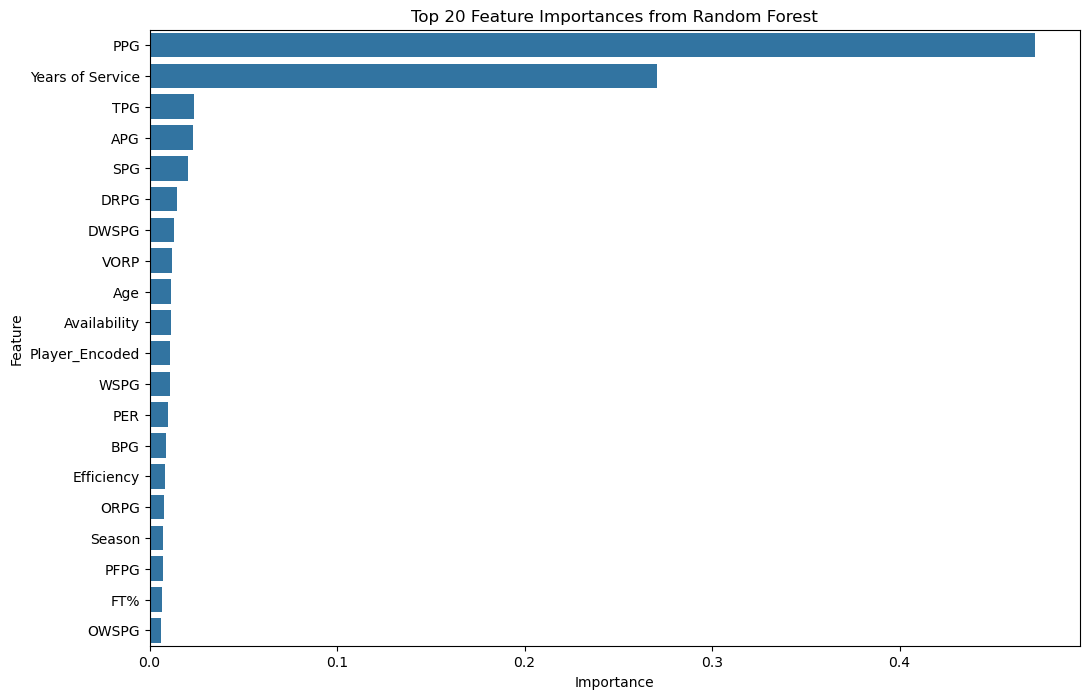


Tree-based feature importances:
             Feature  Importance
11               PPG    0.472460
2   Years of Service    0.270644
13               TPG    0.023479
12               APG    0.023373
14               SPG    0.020618
24              DRPG    0.014516
20             DWSPG    0.013068
8               VORP    0.012142
1                Age    0.011218
16      Availability    0.011154
25    Player_Encoded    0.010957
19              WSPG    0.010663
7                PER    0.009862
15               BPG    0.008544
17        Efficiency    0.008163
23              ORPG    0.007709
0             Season    0.007337
22              PFPG    0.007270
6                FT%    0.006338
21             OWSPG    0.005791


In [18]:
# %%writefile ../src/model_predictor.py

import joblib
import pandas as pd
import os
import logging

# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_models_and_utils(model_save_path, general_utils_path):
    logger.debug(f"Loading models and utilities from {model_save_path} and {general_utils_path}.")
    
    # Load models
    rf_model = joblib.load(f"{model_save_path}/best_rf_model.pkl")
    xgb_model = joblib.load(f"{model_save_path}/best_xgb_model.pkl")
    scaler = joblib.load(f"{model_save_path}/scaler.pkl")
    feature_names = joblib.load(f"{model_save_path}/feature_names.pkl")
    encoders = joblib.load(f"{model_save_path}/encoders.pkl")
    
    # Load general utilities
    injury_risk_mapping = joblib.load(f"{general_utils_path}/injury_risk_mapping.pkl")
    numeric_cols = joblib.load(f"{general_utils_path}/numeric_cols.pkl")
    player_encoder = joblib.load(f"{general_utils_path}/player_encoder.pkl")
    
    logger.debug("Models and utilities loaded successfully.")
    
    return rf_model, xgb_model, scaler, feature_names, encoders, injury_risk_mapping, numeric_cols, player_encoder

def predict(data, model_save_path, general_utils_path):
    logger.debug(f"Starting prediction process for data with shape: {data.shape}")
    
    rf_model, xgb_model, scaler, feature_names, encoders, injury_risk_mapping, numeric_cols, player_encoder = load_models_and_utils(model_save_path, general_utils_path)
    
    logger.debug(f"Data columns before any processing: {data.columns.tolist()}")
    
    # Preserve player names
    player_names = data['Player'] if 'Player' in data.columns else None
    
    # Drop the player column before encoding
    data = data.drop(columns=['Player'], errors='ignore')
    
    # Encode the data using the loaded encoders
    encoded_data, _, encoders, scaler, numeric_cols, player_encoder, _ = encode_data(data, encoders, player_encoder)
    
    logger.debug(f"Encoded data shape: {encoded_data.shape}")
    logger.debug(f"Encoded data columns: {encoded_data.columns.tolist()}")
    
    # Align features with those used in training
    for col in feature_names:
        if col not in encoded_data.columns:
            logger.debug(f"Feature '{col}' is missing in encoded data. Adding it with zeros.")
            encoded_data[col] = 0
    
    encoded_data = encoded_data[feature_names]
    
    logger.debug(f"Final selected features shape: {encoded_data.shape}")
    logger.debug(f"Final selected features (in correct order): {encoded_data.columns.tolist()}")
    
    # Scale the encoded data
    encoded_data_scaled = scaler.transform(encoded_data)
    
    logger.debug(f"Data scaling completed. Scaled data shape: {encoded_data_scaled.shape}")
    
    # Make predictions
    logger.debug(f"Making predictions with RandomForest and XGBoost models.")
    rf_predictions = rf_model.predict(encoded_data_scaled)
    xgb_predictions = xgb_model.predict(encoded_data_scaled)
    
    logger.debug("Predictions made successfully.")
    
    # Create a DataFrame for predictions
    predictions_df = pd.DataFrame({
        'RF_Predictions': rf_predictions,
        'XGB_Predictions': xgb_predictions,
        'Predicted_Salary_Pct': (rf_predictions + xgb_predictions) / 2
    })
    
    # Attach player names back to the predictions
    if player_names is not None:
        predictions_df['Player'] = player_names.values
    
    # Combine the predictions with the original data (excluding player names)
    result = pd.concat([data.reset_index(drop=True), predictions_df], axis=1)
    
    # Decode the predicted data
    decoded_data = decode_data(result, injury_risk_mapping, encoders, scaler, numeric_cols, player_encoder, data)
    
    # Calculate the actual predicted salary
    if 'Salary_Cap_Inflated' in decoded_data.columns:
        decoded_data['Predicted_Salary'] = decoded_data['Predicted_Salary_Pct'] * decoded_data['Salary_Cap_Inflated']
    
    logger.debug("Final prediction result prepared and decoded.")
    
    return decoded_data



def filter_seasons(data, predict_season):
    """
    Filters the dataset into prior seasons and the target season for prediction.

    Args:
        data (pd.DataFrame): The dataset containing season data.
        predict_season (int): The season that you want to predict.

    Returns:
        tuple: A tuple containing two DataFrames:
            - prior_seasons_data: Data for seasons before the predict_season.
            - target_season_data: Data for the predict_season.
    """
    # Separate data into prior seasons and the target season
    prior_seasons_data = data[data['Season'] < predict_season]
    target_season_data = data[data['Season'] == predict_season]
    
    print(f"Data filtered. Prior seasons shape: {prior_seasons_data.shape}, Target season shape: {target_season_data.shape}")
    
    return target_season_data, prior_seasons_data

if __name__ == "__main__":
    file_path = '../data/processed/nba_player_data_final_inflated.csv'
    predict_season = 2023
    general_utils_path = '../data/models'  # Path to the general utilities
    
    logger.info(f"Loading data from {file_path}")
    data = load_data(file_path)
    
    logger.info("Formatting season column")
    data = format_season(data)
    
    logger.info(f"Filtering data for season {predict_season}")
    current_season_data, _ = filter_seasons(data, predict_season)
    
    logger.info("Cleaning data")
    current_season_data = clean_data(current_season_data)
    
    logger.info("Engineering features")
    current_season_data = engineer_features(current_season_data)
    
    # Dynamically determine model save path based on the prediction season
    model_save_path = f'../data/models/season_{predict_season}'
    
    if not os.path.exists(model_save_path):
        logger.error(f"Model directory for season {predict_season} not found at {model_save_path}.")
        raise FileNotFoundError(f"Model directory for season {predict_season} not found at {model_save_path}.")
    
    logger.info("Starting prediction")
    predictions_df = predict(current_season_data, model_save_path, general_utils_path)
    
    logger.info("Saving predictions")
    predictions_df.to_csv(f'../data/processed/predictions_{predict_season}.csv', index=False)
    logger.info("Predictions saved successfully")


In [25]:
feature_names_path = '../data/models/season_2023/feature_names.pkl'

# Load the feature names
feature_names = joblib.load(feature_names_path)
feature_names

Index(['PPG', 'APG', 'SPG', 'Years of Service', 'PER', 'VORP', 'WSPG', 'OWSPG',
       'Injury_Risk', 'Position_Center', 'Position_Center-Forward',
       'Position_Forward', 'Position_Forward-Center', 'Position_Forward-Guard',
       'Position_Guard', 'Position_Guard-Forward', 'Team_ATL', 'Team_BKN',
       'Team_BOS', 'Team_CHA', 'Team_CHI', 'Team_CLE', 'Team_DAL', 'Team_DEN',
       'Team_DET', 'Team_GSW', 'Team_HOU', 'Team_IND', 'Team_LAC', 'Team_LAL',
       'Team_MEM', 'Team_MIA', 'Team_MIL', 'Team_MIN', 'Team_NOP', 'Team_NYK',
       'Team_OKC', 'Team_ORL', 'Team_PHI', 'Team_PHX', 'Team_POR', 'Team_SAC',
       'Team_SAS', 'Team_TOR', 'Team_UTA', 'Team_WAS'],
      dtype='object')